In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def watermark_encoding(img, w_binary):
    BS=8*8
    l=30
    T=2
    u=3.9
    x0=0.7
    k=[x0,]
    for i in range(1, img.size//BS):
        #k.append(1-(u*(k[i-1]**2)))
        k.append(u*k[i-1]*(1-k[i-1]))
    #print(len(set(k)))
    x=k[:]
    k.sort()
    for i in range(img.size//BS):
        x[i] = k.index(x[i])
    temp=w_binary.flatten()
    w_scrambled=[]
    for i in range(img.size//BS):
        w_scrambled.append(temp[x[i]])
    w_scrambled=np.array(w_scrambled)
    w_scrambled=w_scrambled.reshape(32, 32)
    return w_scrambled

In [3]:
# Function to decode the scrambled watermark after extration
def watermark_decoding(w_scrambled, u, x0, img):
    BS=8*8
    l=30
    T=2
    k=[x0,]
    for i in range(1, img.size//BS):
        #k.append(1-(u*(k[i-1]**2)))
        k.append(u*k[i-1]*(1-k[i-1]))
    x=k[:]
    k.sort()
    for i in range(img.size//BS):
        x[i] = k.index(x[i])
    temp=w_scrambled.flatten()
    w_extracted=[]
    for i in range(img.size//BS):
        w_extracted.append(temp[x.index(i)])
    w_extracted=np.array(w_extracted)
    w_extracted=w_extracted.reshape(32, 32)
    
    plt.figure()
    plt.imshow(w_extracted,cmap='gray')
    plt.title( "Extracted Watermark")
    return w_extracted

In [4]:
def surrounding(B, x, y, r2):
    cn=0
    neighbours=[]
    try:
        if B[x-1][y+1] in r2:
            cn=cn+1
            neighbours.append([x-1, y+1])
    except:
        pass
    try:
        if B[x][y+1] in r2:
            cn=cn+1
            neighbours.append([x, y+1])
    except:
        pass
    try:
        if B[x+1][y+1] in r2:
            cn=cn+1
            neighbours.append([x+1, y+1])
    except:
        pass
    try:
        if B[x-1][y] in r2:
            cn=cn+1
            neighbours.append([x-1, y])
    except:
        pass
    try:
        if B[x+1][y] in r2:
            cn=cn+1
            neighbours.append([x+1, y])
    except:
        pass
    try:
        if B[x-1][y-1] in r2:
            cn=cn+1
            neighbours.append([x-1, y-1])
    except:
        pass
    try:
        if B[x][y-1] in r2:
            cn=cn+1
            neighbours.append([x, y-1])
    except:
        pass
    try:
        if B[x+1][y-1] in r2:
            cn=cn+1
            neighbours.append([x+1, y-1])
    except:
        pass
    return cn, neighbours

In [5]:
def mean_func(B, no_neighbour, neighbours):
    sum=0
    mean=0
    for k in range(no_neighbour):
        sum=sum+B[neighbours[k][0]][neighbours[k][1]]
    if(no_neighbour!=0):
        mean=sum//no_neighbour
    return mean

In [6]:
def argmax(weight):
    x, y = np.where(weight==max(max(x) for x in weight))
    #print(x, y)
    return x, y

In [7]:
def low_freq_construct(B, r1, r2, c):
    cn=0
    h, w = B.shape
    no_neighbour=np.zeros((h, w), dtype=int)
    mean=np.zeros((h, w), dtype=int)
    weight=np.zeros((h, w), dtype=int)
    modified=[]
    while cn!= c:
        for i in range(h):
            for j in range(w):
                if B[i][j] in r1:
                    no_neighbour[i][j], neighbours=surrounding(B, i, j, r2)
                    mean[i][j] = mean_func(B, no_neighbour[i][j], neighbours)
                    weight[i][j]=32*no_neighbour[i][j]-abs(mean[i][j]-B[i][j])
                for e in modified:
                    weight[e[0]][e[1]]=0
        x, y=argmax(weight)
        #print(x[0], y[0])
        #print('Block:\n', B, '\nMean:\n', mean)
        B[x[0]][y[0]]=mean[x[0]][y[0]]
        modified.append([x[0], y[0]])
        cn=cn+1

In [8]:
def block_embedding(B, T, l, s):
    vals = B.flatten()
    H, bins=np.histogram(vals, range(257))
    F_max = max(H)
    loc=np.where(H==F_max)[0]
    P_max = loc[len(loc)//2]
    a = 0
    b = 0
    for i in range(l):
        a=a+H[P_max-l+i]
        b=b+H[P_max+1+i]
    if (s==0) and (b/a<T):
        c=(T*a-b)//(1+T)
        low_freq_construct(B, [x for x in range(P_max-l, P_max-1)], [x for x in range(P_max+1, P_max+l)], c)
    elif (s==1) and (a/b<T):
        c=(T*b-a)//(1+T)
        low_freq_construct(B, [x for x in range(P_max+1, P_max+l)], [x for x in range(P_max-l, P_max-1)],  c)
    return B

In [9]:
def block_extraction(B, T, l, P_max, F_max):
    f = 0
    vals = B.flatten()
    H, bins=np.histogram(vals, range(257))
    F = max(H)
    loc=np.where(H==F)[0]
    P = loc[len(loc)//2]
    if F!=F_max or P!=P_max:
        f = 1
    a=0
    b=0
    for i in range(l):
        a=a+H[P_max-l+i]
        b=b+H[P_max+1+i]
    if a<b:
        s=0
    else:
        s=255
    return s, f

In [10]:
def watermark_extraction(blocks, T, l, carrier):
    F_max_blocks=[]
    P_max_blocks=[]
    for r in range(carrier.shape[0]//8):  # loop vertically
        for c in range(carrier.shape[1]//8):  # loop horizontally
            block = carrier[r*8:(r+1)*8, c*8:(c+1)*8]
            vals = block.flatten()
            H, bins=np.histogram(vals, range(257))
            F_max = max(H)
            loc=np.where(H==F_max)[0]
            P_max = loc[len(loc)//2]
            F_max_blocks.append(F_max)
            P_max_blocks.append(P_max)  
    w_extracted=np.zeros((32, 32), dtype=int)
    count = 0
    attack_count = 0
    for i in range(0,32):
      for j in range(0,32):
        s, f =block_extraction(blocks[count], T, l, P_max_blocks[count], F_max_blocks[count])
        if (f == 1):
          attack_count += 1
        w_extracted[i][j]=s
        count=count+1
    return w_extracted, attack_count

Text(0.5, 1.0, 'Carrier Image')

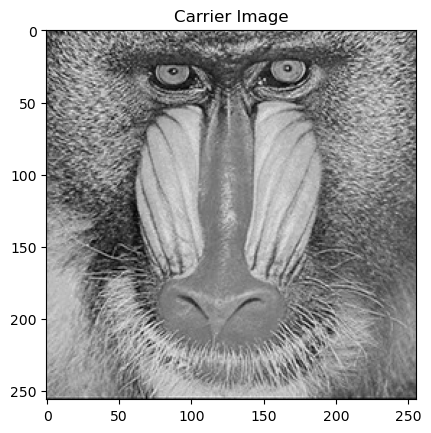

In [11]:
img=cv2.imread('Baboon 256.png')
transcol=cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
carrier=transcol[:,:,0]

plt.figure()
plt.imshow(carrier,cmap='gray')
plt.title( "Carrier Image")

Text(0.5, 1.0, 'Watermarked Image')

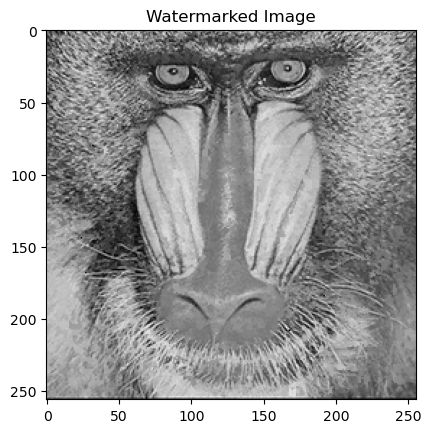

In [12]:
img=cv2.imread('Baboon Watermarked.png')
transcol=cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
watermarked=transcol[:,:,0]
img = np.copy(watermarked)

plt.figure()
plt.imshow(watermarked,cmap='gray')
plt.title( "Watermarked Image")

In [13]:
# Dividing watermarked image into non-overlapping blocks
blocks=[]
for r in range(watermarked.shape[0]//8):  # loop vertically
    for c in range(watermarked.shape[1]//8):  # loop horizontally
        block = watermarked[r*8:(r+1)*8, c*8:(c+1)*8]
        blocks.append(block)

Text(0.5, 1.0, 'Second Watermark')

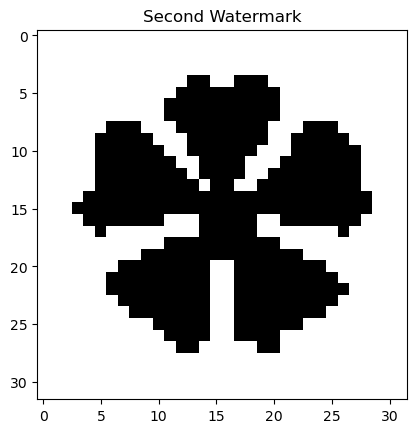

In [14]:
# Reading the second watermark to be inserted
w_gray = cv2.imread('Watermark 2.png', cv2.IMREAD_GRAYSCALE)
thresh = 128
w_binary = cv2.threshold(w_gray, thresh, 255, cv2.THRESH_BINARY)[1]
plt.figure()
plt.imshow(w_binary,cmap='gray')
plt.title( "Second Watermark")

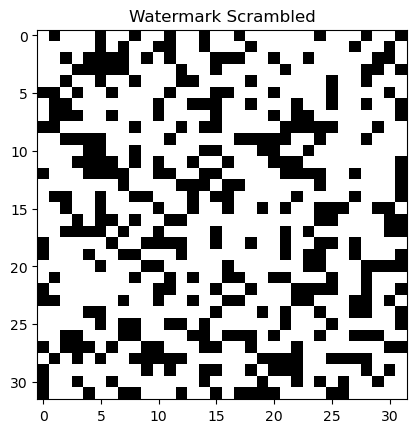

In [15]:
w_scrambled=watermark_encoding(img, w_binary)
cv2.imwrite("Watermark 2 Scrambled.png", w_scrambled)

plt.figure()
plt.imshow(w_scrambled,cmap='gray')
plt.title( "Watermark Scrambled")
plt.show()

C:\Users\vehere\AppData\Local\Temp\ipykernel_14760\223388693.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  elif (s==1) and (a/b<T):
C:\Users\vehere\AppData\Local\Temp\ipykernel_14760\223388693.py:15: RuntimeWarning: invalid value encountered in scalar divide
  elif (s==1) and (a/b<T):


Text(0.5, 1.0, 'After Embedding Second Watermark')

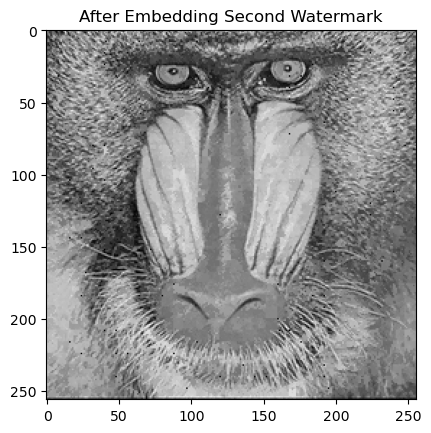

In [16]:
count = 0
for i in range(0,32):
  for j in range(0,32):
    s=0 if w_scrambled[i][j]==0 else 1
    blocks[count]=block_embedding(blocks[count], 5, 15, s)
    count+=1
      
count=0
for r in range(watermarked.shape[0]//8):
    for c in range(watermarked.shape[1]//8):
        watermarked[r*8:(r+1)*8, c*8:(c+1)*8]=blocks[count]
        count+=1
        
cv2.imwrite("Baboon Collusion Attack.png", watermarked)
plt.figure()
plt.imshow(watermarked,cmap='gray')
plt.title( "After Embedding Second Watermark")

Image has been attacked; 846 of 1024 image blocks detected alteration


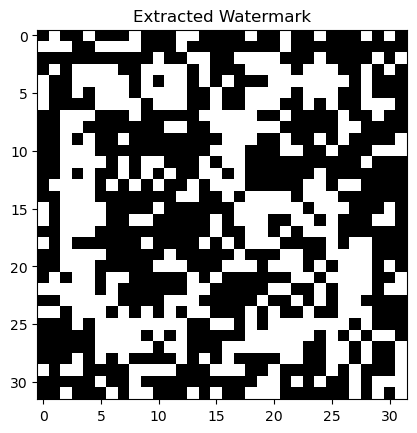

In [17]:
w_extracted=np.zeros((32, 32), dtype=int)
w_extracted, attack_count = watermark_extraction(blocks, 2, 30, carrier)
w_decoded=watermark_decoding(w_extracted, 4, 0.6, carrier)
cv2.imwrite("Watermark 1 Extracted.png", w_decoded)
if attack_count != 0:
    print("Image has been attacked;", attack_count, "of", len(blocks), "image blocks detected alteration")

Image has been attacked; 846 of 1024 image blocks detected alteration


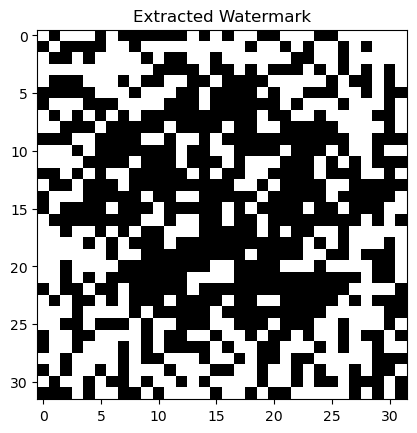

In [18]:
w_extracted=np.zeros((32, 32), dtype=int)
w_extracted, attack_count = watermark_extraction(blocks, 5, 15, carrier)
w_decoded=watermark_decoding(w_extracted, 3.9, 0.7, carrier)
cv2.imwrite("Watermark 2 Extracted.png", w_decoded)
if attack_count != 0:
    print("Image has been attacked;", attack_count, "of", len(blocks), "image blocks detected alteration")

In [19]:
from math import log10, sqrt

def PSNR(original, compressed):
	mse = np.mean((original - compressed) ** 2)
	if(mse == 0): # MSE is zero means no noise is present in the signal .
				# Therefore PSNR have no importance.
		return 100
	max_pixel = 255.0
	psnr = 20 * log10(max_pixel / sqrt(mse))
	return psnr

original = cv2.imread("Baboon Grayscale.png")
watermarked_1 = cv2.imread("Baboon Watermarked.png", 1)
watermarked_2 = cv2.imread("Baboon Collusion Attack.png", 1)
value_1 = PSNR(original, watermarked_1)
value_2 = PSNR(original, watermarked_2)
print(f"PSNR value 1 is {value_1} dB")
print(f"PSNR value 2 is {value_2} dB")

PSNR value 1 is 37.01507195927806 dB
PSNR value 2 is 34.416181711063004 dB


In [20]:
import math

def NC(original, extracted):
    numerator =  0
    denominator_1 = 0
    denominator_2 = 0
    for i in range(original.shape[0]):
        for j in range(original.shape[1]):
            numerator += original[i][j] * extracted[i][j]
            denominator_1 += original[i][j] ** 2
            denominator_2 += extracted[i][j] ** 2
    denominator_1 = math.sqrt(denominator_1)
    denominator_2 = math.sqrt(denominator_2)
    return numerator / (denominator_1 * denominator_2)

def mu(original, extracted):
    pixel_diff =  0
    for i in range(original.shape[0]):
        for j in range(original.shape[1]):
            if (original[i][j] != extracted[i][j]):
                pixel_diff +=  1
    return 1 - (pixel_diff / (32*32))

thresh = 128
original_1 = cv2.imread("Watermark.png", cv2.IMREAD_GRAYSCALE)
original_1 = cv2.threshold(original_1, thresh, 1, cv2.THRESH_BINARY)[1]
original_2 = cv2.imread("Watermark 2.png", cv2.IMREAD_GRAYSCALE)
original_2 = cv2.threshold(original_2, thresh, 1, cv2.THRESH_BINARY)[1]
extracted_1 = cv2.imread("Watermark 1 Extracted.png", cv2.IMREAD_GRAYSCALE)
extracted_1 = cv2.threshold(extracted_1, thresh, 1, cv2.THRESH_BINARY)[1]
extracted_2 = cv2.imread("Watermark 2 Extracted.png", cv2.IMREAD_GRAYSCALE)
extracted_2 = cv2.threshold(extracted_2, thresh, 1, cv2.THRESH_BINARY)[1]
value_1 = NC(original_1, extracted_1)
value_2 = NC(original_2, extracted_2)
print(f"NC value of 1st extracted watermark {value_1}")
print(f"NC value of 2nd extracted watermark {value_2}")

NC value of 1st extracted watermark 0.6128382316188202
NC value of 2nd extracted watermark 0.714303562838958
